# Лабораторная работа № 1: Метод обратного распространения ошибки
## Клименко Ксения, 3824М1ФИ1

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

from random import randint

from time import time

## Загрузка данных MNIST

In [2]:
def load_images(path_to_images):
    images = np.fromfile(path_to_images, dtype=np.uint8, count= -1)[16:]
    return images


def load_labels(path_to_labels):
    labels = np.fromfile(path_to_labels, dtype=np.uint8, count=-1)[8:]
    return labels

In [3]:
training_images_filepath = "../../MNIST/train-images.idx3-ubyte"
training_labels_filepath = "../../MNIST/train-labels.idx1-ubyte"

test_images_filepath = "../../MNIST/t10k-images.idx3-ubyte"
test_labels_filepath = "../../MNIST/t10k-labels.idx1-ubyte"

x_train = load_images(training_images_filepath)
x_test = load_images(test_images_filepath)

y_train = load_labels(training_labels_filepath)
y_test = load_labels(test_labels_filepath)

x_train = x_train.reshape(-1, 28, 28)
x_test = x_test.reshape(-1, 28, 28)

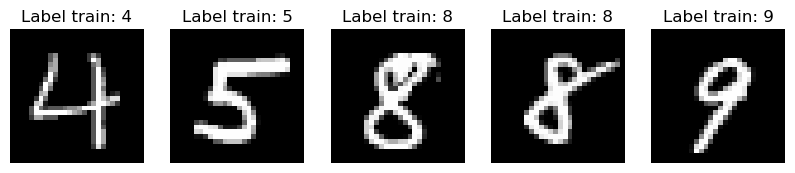

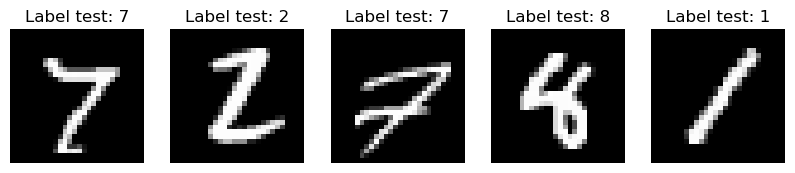

In [ ]:
plt.figure(figsize=(10, 5))
for i in range(5):
    random_index_train = randint(1, x_train.shape[0])
    plt.subplot(1, 5, i + 1)
    plt.imshow(x_train[random_index_train], cmap='gray')
    plt.title(f'Label train: {y_train[random_index_train]}')
    plt.axis('off')
plt.show()

plt.figure(figsize=(10, 5))
for i in range(5):
    random_index_test = randint(1, x_test.shape[0])
    plt.subplot(1, 5, i + 1)
    plt.imshow(x_test[random_index_test], cmap='gray')
    plt.title(f'Label test: {y_test[random_index_test]}')
    plt.axis('off')
plt.show()

In [5]:
x_train = x_train.reshape(-1, 784)
x_test = x_test.reshape(-1, 784)

print('Размерность тренировочных данных:')
print(f"x_train: {x_train.shape}, y_train: {y_train.shape}")
print("----------------------------------")
print('Размерность тестовых данных:')
print(f"x_test: {x_test.shape}, y_test: {y_test.shape}")

Размерность тренировочных данных:
x_train: (60000, 784), y_train: (60000,)
----------------------------------
Размерность тестовых данных:
x_test: (10000, 784), y_test: (10000,)


## Предобработка данных

In [6]:
x_train = x_train / 255
x_test = x_test / 255

In [7]:
y_test = np.eye(10)[y_test]
y_train = np.eye(10)[y_train]

## Алгоритм обратного распространения ошибки

### Инициализация параметров нейронной сети

In [8]:
def initialize_network_parameters(input_size, hidden_size, output_size):

    W1 = np.random.randn(input_size, hidden_size) * np.sqrt(2. / input_size)
    W2 = np.random.randn(hidden_size, output_size) * np.sqrt(2. / hidden_size)

    b1 = np.zeros((1, hidden_size))
    b2 = np.zeros((1, output_size))

    return W1, b1, W2, b2

### Функции активации

#### На скрытом слое: ReLU

In [9]:
def Relu(Z):
    return np.maximum(Z, 0)

def Relu_derivative(Z):
    return Z > 0

#### На выходном слое: softmax

In [10]:
def softmax(Z):
    return np.exp(Z) / np.sum(np.exp(Z), axis=1, keepdims=True)

### Функция ошибки: кросс-энтропия

In [11]:
def cross_entropy(Y, A2):
    return np.mean(-np.sum(Y * np.log(A2), axis=1))

In [12]:
def forward_propagation(X, w1, b1, w2, b2):

    Z1 = np.dot(X, w1) + b1
    A1 = Relu(Z1)

    Z2  = np.dot(A1, w2) + b2
    A2 = softmax(Z2)

    return Z1, A1, Z2, A2


def backward_propagation(X, Y, Z1, A1, Z2, A2, w2):

    L = Y.shape[0]

    dZ2 = A2 - Y

    dW2 = np.dot(A1.T, dZ2) / L
    db2 = np.sum(dZ2, axis=0, keepdims=True) / L

    dA1 = np.dot(dZ2, w2.T)
    dZ1 = dA1 * Relu_derivative(Z1)

    dW1 = np.dot(X.T, dZ1) / L
    db1 = np.sum(dZ1, axis=0, keepdims=True) / L

    return dW1, db1, dW2, db2


def update_parameters_network(W1, b1, W2, b2,
                              dW1, db1, dW2, db2, learning_rate):

    W1 -= learning_rate * dW1
    b1 -= learning_rate * db1
    W2 -= learning_rate * dW2
    b2 -= learning_rate * db2

    return W1, b1, W2, b2

In [13]:
def accuracy(Y, A2):
  return np.mean(np.argmax(A2, axis = 1) == np.argmax(Y, axis = 1))

In [14]:
def train_network(x_train, y_train, x_test, y_test,
                  input_layer_size, hiiden_layer_size, output_layer_size,
                  count_epoch, batch_size, learning_rate):

    W1, b1, W2, b2 = initialize_network_parameters(input_layer_size,
                            hiiden_layer_size, output_layer_size)

    total_time_start = time()

    for epoch in range(count_epoch):

        epoch_time_start = time()
        shuffle = np.random.permutation(x_train.shape[0])
        x_train_shuffled = x_train[shuffle]
        y_train_shuffled = y_train[shuffle]

        for batch in range(0, x_train.shape[0], batch_size):

            x_batch = x_train_shuffled[batch:batch+batch_size]
            y_batch = y_train_shuffled[batch:batch+batch_size]

            Z1, A1, Z2, A2 = forward_propagation(x_batch, W1, b1, W2, b2)

            dW1, db1, dW2, db2 = backward_propagation(x_batch, y_batch,
                        Z1, A1, Z2, A2, W2)

            W1, b1, W2, b2 = update_parameters_network(W1, b1, W2, b2,
                              dW1, db1, dW2, db2, learning_rate)

        _, _, _ , predictions = forward_propagation(x_train, W1, b1, W2, b2)

        loss = cross_entropy(y_train, predictions)
        accuracy_train = accuracy(predictions, y_train)

        epoch_time_end = time()

        print(f"Epoch: {epoch}. Time in epoch: {epoch_time_end - epoch_time_start: .2f} s. Loss: {loss: .4f}. Accuracy train: {accuracy_train: .4f}.")
        print("-----------------------------------------------------------------------")

    print(f"Total time: {time() - total_time_start: .2f} s.")
    _, _, _, predictions = forward_propagation(x_test, W1, b1, W2, b2)
    loss_test = cross_entropy(y_test, predictions)
    accuracy_test = accuracy(predictions, y_test)

    print("")
    print("Testing:")
    print(f"Loss test: {loss_test: .4f}")
    print(f"Accuracy test: {accuracy_test: .4f}")

## Начальные параметры сети

In [15]:
input_layer_size = 28 * 28
hidden_layer_size = 300
output_size = 10
count_epoch = 20
batch_size = 32
learning_rate = 0.1

## Обучение модели

In [16]:
train_network(x_train, y_train, x_test, y_test,
              input_layer_size, hidden_layer_size, output_size,
              count_epoch, batch_size, learning_rate)

Epoch: 0. Time in epoch:  11.45 s. Loss:  0.1479. Accuracy train:  0.9602.
-----------------------------------------------------------------------
Epoch: 1. Time in epoch:  10.82 s. Loss:  0.0976. Accuracy train:  0.9735.
-----------------------------------------------------------------------
Epoch: 2. Time in epoch:  10.29 s. Loss:  0.0693. Accuracy train:  0.9816.
-----------------------------------------------------------------------
Epoch: 3. Time in epoch:  10.06 s. Loss:  0.0603. Accuracy train:  0.9829.
-----------------------------------------------------------------------
Epoch: 4. Time in epoch:  10.29 s. Loss:  0.0482. Accuracy train:  0.9871.
-----------------------------------------------------------------------
Epoch: 5. Time in epoch:  10.59 s. Loss:  0.0373. Accuracy train:  0.9898.
-----------------------------------------------------------------------
Epoch: 6. Time in epoch:  13.01 s. Loss:  0.0302. Accuracy train:  0.9926.
-------------------------------------------